In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import pathlib

import config as cfg

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

import copy

from save_results import save_results_smart, list_saved_configs
from nlg_metrics import Metrics

/home/nad/studies/Transformer-Image-Captioning-IIW/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/nad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/nad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
importlib.reload(cfg)
torch.cuda.empty_cache()

## Define Parameters

In [3]:
config = cfg.make_config()

In [4]:
batch_size_train = config["BATCH_SIZE_TRAIN"]
batch_size_test = config["BATCH_SIZE_TEST"]

H = config["IMG_HEIGHT"]
W = config["IMG_WIDTH"]
P = config["PATCH_SIZE"]
D_IMG = config["IMG_EMBEDDING_DIM"]

# The data will get truncated/padded to this length AFTER tokenization
L = config["MAX_TEXT_SEQUENCE_LENGTH"]
D_TEXT = config["TEXT_EMBEDDING_DIM"]
DROPOUT_DEC = config["DECODER_DROPOUT_PROB"]
RANDOM_SEED = config["RANDOM_SEED"]

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(42)

## Build Dataset

In [6]:
data_loader = DatasetLoader(dataset_type=config["DATASET"],
                            img_height=H,
                            img_width=W,
                            batch_size_train=batch_size_train, 
                            batch_size_test=batch_size_test,
                            split_ratio=config["SPLIT_RATIO"],
                            shuffle_test=True,
                            seed=RANDOM_SEED)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading COCO dataset...


## Inspect Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0648367].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Cli

Number of training samples: 32403
Number of test samples: 8101
torch.Size([16, 3, 224, 224])
Caption: A man with a beard standing on the beach with a surfboard under his right arm and he is looking out into the ocean.
torch.Size([16, 3, 224, 224])
Caption: A street sign sitting on the side of a road next to a tall brick building.
torch.Size([16, 3, 224, 224])
Caption: A woman standing in front of an apple.
torch.Size([16, 3, 224, 224])
Caption: A car with open doors is towing boating equipment.
torch.Size([16, 3, 224, 224])
Caption: A kitchen sink inside of a center island.
torch.Size([16, 3, 224, 224])
Caption: A cow getting relief as it is being milked.
torch.Size([16, 3, 224, 224])
Caption: A gas station and a traffic light.
torch.Size([16, 3, 224, 224])
Caption: A white kitchen counter next to an oven.
torch.Size([16, 3, 224, 224])
Caption: A young person using a hair dryer near bunk beds.
torch.Size([16, 3, 224, 224])
Caption: Five statues of people on a pavement
torch.Size([16, 3

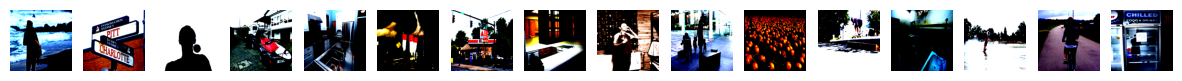

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.5179958].
Clipp

torch.Size([16, 3, 224, 224])
Caption: A person carries a stack of boxes while people with umbrellas walk around the street.
torch.Size([16, 3, 224, 224])
Caption: A man with a remote in a small room.
torch.Size([16, 3, 224, 224])
Caption: Two people are standing and talking to each other with a bus in the background.
torch.Size([16, 3, 224, 224])
Caption: A close up of a country sign, the picture is a personified bus that is freaking out because it is about to hit a biker, and the sign below reads 'danger traversee de route'.
torch.Size([16, 3, 224, 224])
Caption: People preparing to ski down a snow covered slope.
torch.Size([16, 3, 224, 224])
Caption: A sandwich cut in half and onion rings arranged on a plate.
torch.Size([16, 3, 224, 224])
Caption: A dog is standing next to a toilet playing with tissue
torch.Size([16, 3, 224, 224])
Caption: A child on a horse riding down a busy city street.
torch.Size([16, 3, 224, 224])
Caption: Group of people outside and one pointing up to the sky.

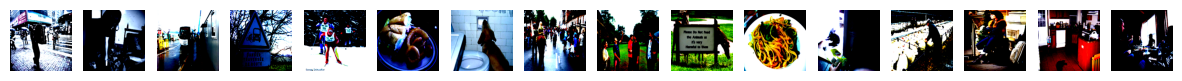

In [7]:
# dataset stats
print(f"Number of training samples: {len(train_dataloader.dataset)}")
print(f"Number of test samples: {len(test_dataloader.dataset)}")

# plot some samples from the dataset
data_iter = iter(test_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_test, figsize=(15, 5))
for i in range(batch_size_test):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

data_iter = iter(train_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_train, figsize=(15, 5))
for i in range(batch_size_train):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

## Initialize Tokenizer

In [8]:
special_tokens = [cfg.SpecialTokens.PAD, cfg.SpecialTokens.BOS, cfg.SpecialTokens.EOS]
if config["TOKENIZER_TYPE"] == cfg.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config["TOKENIZER_TYPE"] == cfg.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=config["TOKENIZER_DATA_PATH"], filename_prefix=config["TOKENIZER_FILENAME_PREFIX"])
    
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}, Pad token ID: {pad_idx}")

Tokenizer vocab size: 8577, Pad token ID: 0


## Initialize Metrics

In [9]:
nlg_metrics = Metrics()

## Configure Model

In [10]:
transformer = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)

Initialized CNN ResNet-50 Encoder


## Training code

### Early Stopping and Checkpoint Loading

In [11]:
class EarlyStopping:
    def __init__(self, patience, delta, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.best_bleu = None
        self.best_meteor = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_model_state = None
        self.best_bleu_state = None
        self.best_meteor_state = None
    
    def check_early_stop(self, val_loss, val_bleu, val_meteor, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print("Stopping early as no improvement has been observed.")
        if self.best_bleu is None or val_bleu > self.best_bleu + self.delta:
            self.best_bleu = val_bleu
            self.best_bleu_state = copy.deepcopy(model.state_dict())
        if self.best_meteor is None or val_meteor > self.best_meteor + self.delta:
            self.best_meteor = val_meteor
            self.best_meteor_state = copy.deepcopy(model.state_dict())

### Train and Evaluate Steps

In [12]:
def train_step(model: torch.nn.Module,
               config,
               dataloader: torch.utils.data.DataLoader,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch in dataloader:
        images = batch["pixel_values"].to(device)
        texts = batch["description"]

        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids']
        tokens = tokens.to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        attention_mask = get_causal_mask(T, device=device)
        padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)

        logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to a max norm of 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def train_step_accumulate(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               config,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               accumulation_steps: int,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    accumulation_steps: Number of steps to accumulate gradients before updating the model.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    model.train()
    train_loss, train_acc = 0, 0
    
    # Reset gradients at the start
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        images = batch["pixel_values"].to(device)
        texts = batch["description"]
        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids'].to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        
        logits, loss = model(
            images=images, 
            text_tokens=decoder_inputs, 
            attn_mask=get_causal_mask(T, device), 
            pad_mask=get_padding_mask(decoder_inputs, pad_idx, device), 
            targets=targets
        )

        # 3. Normalize loss to account for accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # 4. Optimizer Step (only every 'accumulation_steps')
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad() # Clear for next set

        train_loss += (loss.item() * accumulation_steps)

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def test_step(model: torch.nn.Module,
              config,
              dataloader: torch.utils.data.DataLoader,
              tokenizer,
              pad_idx: int,
              device: torch.device, 
              epoch=None, 
              calculate_metrics=False, 
              metrics_calculator=None,
              verbose=False) -> Tuple[float, float, float, Dict[str, float]]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    model.eval()

    test_loss, test_acc = 0, 0
    all_refs = []
    all_hypos = []
    # Turn on inference context manager
    with torch.inference_mode():
        for i, batch in enumerate(dataloader):
          images = batch["pixel_values"].to(device)
          texts = batch["description"]

          outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
          tokens = outputs['input_ids']
          tokens = tokens.to(device)
          tokens = tokens.to(device)

          targets = tokens[:, 1:]
          decoder_inputs = tokens[:, :-1]
          T = decoder_inputs.size(1)
          attention_mask = get_causal_mask(T, device=device)
          padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)
        
          logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

          test_loss += loss.item()

          preds = logits.argmax(dim=-1)
          pad_idx = tokenizer.get_padding_token_id()
          non_pad = targets != pad_idx
          acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
          test_acc += acc.item()
          
          # calculate only last 10 batches to save time
          if calculate_metrics and metrics_calculator and (i >= len(dataloader) - 10):
                decoded_preds = []
                for img in images:
                    generated_tokens = model.generate(img.unsqueeze(0), 
                        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                        max_len=L,
                        device=device)
                    if not isinstance(generated_tokens, torch.Tensor):
                        generated_tokens = torch.tensor(generated_tokens)

                    # NLTK metrics expect lists of words: ["a", "squirrel", "on", "a", "fence"]
                    generated_tokens = tokenizer.decode(generated_tokens) # returns ["sentence 1", "sentence 2", ...] with special tokens
                    # Remove special tokens
                    generated_tokens = tokenizer.strip(generated_tokens)
                    decoded_preds.append(generated_tokens)
                decoded_targets = texts # Ground Truth

                for p, t in zip(decoded_preds, decoded_targets):
                    all_hypos.append(p.split())
                    all_refs.append([t.split()])
          
          if verbose:
            # print produced tokens for debugging
            if epoch is not None and config["NUM_EPOCHS"] - epoch <= 1:  # print only for last 2 epochs
              decoded_preds = tokenizer.decode_batched(preds)
              decoded_targets = tokenizer.decode_batched(targets)
              for dp, dt in zip(decoded_preds, decoded_targets):
                  print(f"Predicted: {dp} | Target: {dt}")

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_perplexity = torch.exp(torch.tensor(test_loss)).item()
    test_acc = test_acc / len(dataloader)

    metrics_results = {}
    if calculate_metrics and metrics_calculator:
        metrics_results = metrics_calculator.calculate(all_refs, all_hypos, train=True)

    return test_loss, test_perplexity, test_acc, metrics_results

def train(model: torch.nn.Module,
          config,
          tokenizer, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          device: torch.device,
          return_best_model: bool,
          return_best_bleu: bool,
          return_best_meteor: bool,
          early_stop_patience: int,
          early_stop_delta: float,
          metrics_calculator = None,
          calculate_metrics=False) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    return_best_model: Whether to return the model state with the best performance.
    return_best_bleu: Whether to return the model state with the best BLEU score.

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_perplexity: [...],
              train_acc: [...],
              test_loss: [...],
              test_perplexity: [...],
              test_acc: [...]}
              test_bleu: [...],
              test_meteor: [...],
    """
    results = {"train_loss": [],
               "train_perplexity": [],
               "train_acc": [],
               "test_loss": [],
               "test_perplexity": [],
               "test_acc": [],
               "test_bleu": [],
               "test_meteor": [],
    }
    
    model.to(device)
    
    pad_idx = tokenizer.get_padding_token_id()
    early_stopping = EarlyStopping(patience=early_stop_patience, delta=early_stop_delta, verbose=True)

    for epoch in tqdm(range(epochs)):
        if config["USE_ACCUMULATED_GRADIENTS"]:
            train_loss, train_perplexity, train_acc = train_step_accumulate(model=model,
                                              config=config,
                                              dataloader=train_dataloader,
                                              tokenizer=tokenizer,
                                              pad_idx=pad_idx,
                                              optimizer=optimizer,
                                              scheduler=scheduler,
                                              accumulation_steps=config["ACCUMULATION_STEPS"],
                                              device=device,
                                              epoch=epoch)
        else:
          train_loss, train_perplexity, train_acc = train_step(model=model,
                                            config=config,
                                            dataloader=train_dataloader,
                                            tokenizer=tokenizer,
                                            pad_idx=pad_idx,
                                            optimizer=optimizer,
                                            scheduler=scheduler,
                                            device=device,
                                            epoch=epoch)
        test_loss, test_perplexity, test_acc, test_metrics = test_step(model=model,
                                                         config=config,
                                                         dataloader=test_dataloader,
                                                         tokenizer=tokenizer,
                                                         pad_idx=pad_idx,
                                                         device=device,
                                                         epoch=epoch,
                                                         calculate_metrics=True,
                                                         metrics_calculator=metrics_calculator)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_perplexity: {train_perplexity:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_perplexity: {test_perplexity:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        if calculate_metrics:
            print("NLG metrics:")
            for metric_name, metric_value in test_metrics.items():
                print(f"  {metric_name}: {metric_value:.4f}")

        results["train_loss"].append(train_loss)
        results["train_perplexity"].append(train_perplexity)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_perplexity"].append(test_perplexity)
        results["test_acc"].append(test_acc)
        if calculate_metrics:
            results["test_bleu"].append(test_metrics.get("bleu4", 0.0))
            results["test_meteor"].append(test_metrics.get("meteor", 0.0))

        early_stopping.check_early_stop(val_loss=test_loss, val_bleu=test_metrics.get("bleu4", 0.0), val_meteor=test_metrics.get("meteor", 0.0), model=model)
        if early_stopping.stop_training:
            if return_best_model:
                model.load_state_dict(early_stopping.best_model_state)
            elif return_best_bleu:
                model.load_state_dict(early_stopping.best_bleu_state)
            elif return_best_meteor:
                model.load_state_dict(early_stopping.best_meteor_state)
            break
    
    return results, early_stopping.best_model_state, early_stopping.best_bleu_state, early_stopping.best_meteor_state

### Encoder Training Parameters Tuning

In [13]:
# freeze/unfreeze encoder weights
def config_encoder_params(model, requires_grad: bool):
    if config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_RESNET50:
        if requires_grad == True:
            for layer in model.encoder.backbone[-2:]:  # unfreeze last 2 residual blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.parameters():
                param.requires_grad = False
                
    elif config["ENCODER_ARCH"] == cfg.EncoderArch.VIT_STYLE_BASE or config["ENCODER_ARCH"] == cfg.EncoderArch.VIT_STYLE_LARGE:
        if requires_grad == True:
            for layer in model.encoder.vit.encoder.layer[-3:]:  # unfreeze last 3 transformer blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.parameters():
                param.requires_grad = False
                
    elif config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_CPTR_STYLE:
        if requires_grad == True:
            for layer in model.encoder.patcher.backbone[-2:]:  # unfreeze last 2 residual blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.patcher.parameters():
                param.requires_grad = False
                
    else:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad

In [14]:
if config["USE_ACCUMULATED_GRADIENTS"]:
    effective_steps_per_epoch = len(train_dataloader) // config["ACCUMULATION_STEPS"]
    # Account for the possible partial batch at the end
    if len(train_dataloader) % config["ACCUMULATION_STEPS"] != 0:
        effective_steps_per_epoch += 1
else:
    effective_steps_per_epoch = len(train_dataloader)

## First Training Stage (Frozen Encoder)

In [15]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    config_encoder_params(transformer, requires_grad=False)
    
    optimizer = torch.optim.AdamW(
        [p for p in transformer.parameters() if p.requires_grad],
        lr=config["LR"],
        weight_decay=0.01
    )

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["LR"], 
        steps_per_epoch=effective_steps_per_epoch, 
        epochs=config["NUM_FREEZE_EPOCHS"],
        pct_start=0.05 # 5% of time spent warming up
    )

In [16]:
# Check which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
emb_projector.projection.weight: torch.Size([512, 2048])
emb_projector.layernorm.weight: torch.Size([512])
emb_projector.layernorm.bias: torch.Size([512])
decoder.word_embedding.embedding.weight: torch.Size([8577, 512])
decoder.text_layernorm.weight: torch.Size([512])
decoder.text_layernorm.bias: torch.Size([512])
decoder.decoder_blocks.0.MMHSA.in_proj_weight: torch.Size([1536, 512])
decoder.decoder_blocks.0.MMHSA.out_proj.weight: torch.Size([512, 512])
decoder.decoder_blocks.0.layer_norm_1.weight: torch.Size([512])
decoder.decoder_blocks.0.layer_norm_1.bias: torch.Size([512])
decoder.decoder_blocks.0.MHCA.in_proj_weight: torch.Size([1536, 512])
decoder.decoder_blocks.0.MHCA.out_proj.weight: torch.Size([512, 512])
decoder.decoder_blocks.0.layer_norm_2.weight: torch.Size([512])
decoder.decoder_blocks.0.layer_norm_2.bias: torch.Size([512])
decoder.decoder_blocks.0.FFN.0.weight: torch.Size([2048, 512])
decoder.decoder_blocks.0.FFN.3.weight: torch.Size([512,

In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    # Train the model for freezing phase
    results, best_early_test_state, best_early_bleu_state, best_early_meteor_state = train(model=transformer,
                    config=config,
                    tokenizer=tokenizer,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    epochs=config["NUM_FREEZE_EPOCHS"],
                    device=device,
                    return_best_model=False,
                    return_best_bleu=False,
                    return_best_meteor=True,
                    calculate_metrics=True,
                    metrics_calculator=nlg_metrics,
                    early_stop_patience=config["EARLY_STOPPING_PATIENCE"],
                    early_stop_delta=config["EARLY_STOPPING_DELTA"])
    print('Completed freezing phase.')

  0%|          | 0/20 [00:00<?, ?it/s]

## First Stage Training Evaluation

In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    device = "cpu"
    transformer.to(device)
    transformer_best_state = CPTR(num_patches=config["NUM_PATCHES"],
                       encoder_arch=config["ENCODER_ARCH"],
                       encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                       use_embedding_projection=config["USE_PROJECTION_LAYER"],
                       img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                       img_emb_dim=config["IMG_EMBEDDING_DIM"],
                       patch_size=config["PATCH_SIZE"],
                       text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                       d_model=config["EMBEDDING_DIM"],
                       max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                       vocab_size=vocab_size,
                       pad_idx=pad_idx,
                       channels=config["NUM_INPUT_CHANNELS"],
                       num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                       num_encoder_heads=config["ENCODER_NUM_HEADS"],
                       encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                       encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                       num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                       num_decoder_heads=config["DECODER_NUM_HEADS"],
                       decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                       decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                       bias=config["USE_BIAS"],
                       use_weight_tying=config["USE_WEIGHT_TYING"],
                       sublayer_dropout=config["SUBLAYER_DROPOUT"],
                       verbose=False).to(device)
    transformer_best_state.load_state_dict(best_early_test_state)

    transformer_best_bleu = CPTR(num_patches=config["NUM_PATCHES"],
                       encoder_arch=config["ENCODER_ARCH"],
                       encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                       use_embedding_projection=config["USE_PROJECTION_LAYER"],
                       img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                       img_emb_dim=config["IMG_EMBEDDING_DIM"],
                       patch_size=config["PATCH_SIZE"],
                       text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                       d_model=config["EMBEDDING_DIM"],
                       max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                       vocab_size=vocab_size,
                       pad_idx=pad_idx,
                       channels=config["NUM_INPUT_CHANNELS"],
                       num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                       num_encoder_heads=config["ENCODER_NUM_HEADS"],
                       encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                       encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                       num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                       num_decoder_heads=config["DECODER_NUM_HEADS"],
                       decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                       decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                       bias=config["USE_BIAS"],
                       use_weight_tying=config["USE_WEIGHT_TYING"],
                       sublayer_dropout=config["SUBLAYER_DROPOUT"],
                       verbose=False).to(device)
    transformer_best_bleu.load_state_dict(best_early_bleu_state)

    transformer_best_meteor = CPTR(num_patches=config["NUM_PATCHES"],
                       encoder_arch=config["ENCODER_ARCH"],
                       encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                       use_embedding_projection=config["USE_PROJECTION_LAYER"],
                       img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                       img_emb_dim=config["IMG_EMBEDDING_DIM"],
                       patch_size=config["PATCH_SIZE"],
                       text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                       d_model=config["EMBEDDING_DIM"],
                       max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                       vocab_size=vocab_size,
                       pad_idx=pad_idx,
                       channels=config["NUM_INPUT_CHANNELS"],
                       num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                       num_encoder_heads=config["ENCODER_NUM_HEADS"],
                       encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                       encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                       num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                       num_decoder_heads=config["DECODER_NUM_HEADS"],
                       decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                       decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                       bias=config["USE_BIAS"],
                       use_weight_tying=config["USE_WEIGHT_TYING"],
                       sublayer_dropout=config["SUBLAYER_DROPOUT"],
                       verbose=False).to(device)
    transformer_best_meteor.load_state_dict(best_early_meteor_state)

Initialized ViT Encoder: google/vit-base-patch16-224-in21k
Initialized ViT Encoder: google/vit-base-patch16-224-in21k
Initialized ViT Encoder: google/vit-base-patch16-224-in21k


In [ ]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    return img * IMAGENET_STD + IMAGENET_MEAN

Caption GT:  His and her bathroom sinks underneath a large mirror.
Input image shape: torch.Size([1, 3, 224, 224])


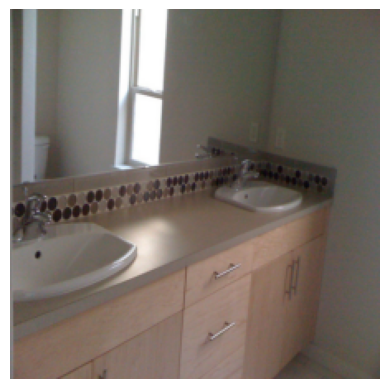

(Longest trained model) Generated caption: <bos>His and her bathroom sinks underneath a large mirror.<eos>
(Best test loss model) Generated caption: <bos>A bathroom with a toilet, sink, toilet, and shower.<eos>
(Best BLEU model) Generated caption: <bos>A bathroom with a white toilet next to a shower.<eos>
(Best METEOR model) Generated caption: <bos>A bathroom with a white toilet next to a shower.<eos>


In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:
        transformer.eval()
        transformer_best_state.eval()
        transformer_best_bleu.eval()
        transformer_best_meteor.eval()
        
        batch = next(iter(train_dataloader))
        image = batch["pixel_values"][0].unsqueeze(0).to(device)
        print('Caption GT: ', batch["description"][0])
        print('Input image shape:', image.shape)
        # plot input image
        img = image[0].cpu()
        img = denormalize(img)
        img = img.clamp(0, 1)
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        tokens = transformer.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=False)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        # print('Generated token ids:', tokens)
        # print(tokens.shape)
        decoded_caption = tokenizer.decode(tokens)
        print('(Longest trained model) Generated caption:', decoded_caption)
        
        tokens = transformer_best_state.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=False)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best test loss model) Generated caption:', decoded_caption)
        
        tokens = transformer_best_bleu.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=False)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best BLEU model) Generated caption:', decoded_caption)
        
        tokens = transformer_best_meteor.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=False)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best METEOR model) Generated caption:', decoded_caption)

Caption GT:  Black and white photo of a man pulling a boat on a beach.
Input image shape: torch.Size([1, 3, 224, 224])


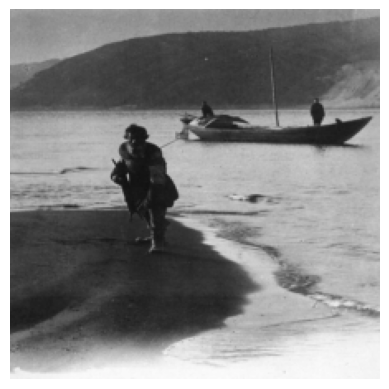

(Longest trained model) Generated caption: <bos>A man riding a surfboard on top of legs.<eos>
(Best test loss model) Generated caption: <bos>A man riding a skateboard on top of ledge.<eos>
(Best BLEU model) Generated caption: <bos>A man riding a surfboard on top of leaf covered ground.<eos>
(Best METEOR model) Generated caption: <bos>A man riding a surfboard on top of leaf covered ground.<eos>


In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:
        batch = next(iter(test_dataloader))
        image = batch["pixel_values"][0].unsqueeze(0).to(device)
        print('Caption GT: ', batch["description"][0])
        print('Input image shape:', image.shape)
        # plot input image
        img = image[0].cpu()
        img = denormalize(img)
        img = img.clamp(0, 1)
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tokens = transformer.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=True)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        # print('Generated token ids:', tokens)
        # print(tokens.shape)
        decoded_caption = tokenizer.decode(tokens)
        print('(Longest trained model) Generated caption:', decoded_caption)

        tokens = transformer_best_state.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=True)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best test loss model) Generated caption:', decoded_caption)

        tokens = transformer_best_bleu.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=True)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best BLEU model) Generated caption:', decoded_caption)

        tokens = transformer_best_meteor.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=True)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best METEOR model) Generated caption:', decoded_caption)

### Intermediate Results Bookkeeping

In [22]:
# if config["NUM_FREEZE_EPOCHS"] > 0:    
#     # export training results to experiments directory
#     timestamp = time.strftime("%Y%m%d-%H%M%S")
#     dir = 'experiments/' + 'config_{}'.format(timestamp)
#     os.makedirs(dir, exist_ok=True)
#     results_path = os.path.join(dir, 'training_results.json')
#     with open(results_path, 'w') as f:
#         json.dump(results, f)
#     # export config to results directory
#     config_path = os.path.join(dir, 'config.json')
#     with open(config_path, 'w') as f:
#         json.dump(config, f)
# 
#     # export model weights
#     model_path = os.path.join(dir, f'cptr_model.pth')
#     torch.save(transformer.state_dict(), model_path)
#     best_loss_model_path = os.path.join(dir, f'cptr_best_loss_model.pth')
#     torch.save(best_early_test_state, best_loss_model_path)
#     best_bleu_model_path = os.path.join(dir, f'cptr_best_bleu_model.pth')
#     torch.save(best_early_bleu_state, best_bleu_model_path)
#     best_meteor_model_path = os.path.join(dir, f'cptr_best_meteor_model.pth')
#     torch.save(best_early_meteor_state, best_meteor_model_path)

## Second Training Stage (Unfrozen Encoder)

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
config_encoder_params(transformer, requires_grad=True)

if config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_RESNET50:
    optimizer = torch.optim.AdamW(
        [
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder.backbone" not in n],
                'lr': config["LR"]
            },
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder.backbone" in n],
                'lr': config["LR"] * 0.1
            }
        ],
        weight_decay=config["WEIGHT_DECAY"]
    )
elif config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_CPTR_STYLE:
    optimizer = torch.optim.AdamW(
        [
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder.patcher.backbone" not in n],
                'lr': config["LR"]
            },
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder.patcher.backbone" in n],
                'lr': config["LR"] * 0.1
            }
        ],
        weight_decay=config["WEIGHT_DECAY"]
    )
else:
    optimizer = torch.optim.AdamW(
        [
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder" not in n],
                'lr': config["LR"]
            },
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder" in n],
                'lr': config["LR"] * 0.1
            }
        ],
        weight_decay=config["WEIGHT_DECAY"]
    )

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#    optimizer,
#    T_max=config["NUM_EPOCHS"],
#    eta_min=5e-7
#)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["LR"], 
        steps_per_epoch=effective_steps_per_epoch, 
        epochs=config["NUM_EPOCHS"],
        pct_start=0.01 # 1% of time spent warming up
    )

In [25]:
# Recheck which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
encoder.vit.encoder.layer.9.attention.attention.query.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.9.attention.attention.query.bias: torch.Size([768])
encoder.vit.encoder.layer.9.attention.attention.key.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.9.attention.attention.key.bias: torch.Size([768])
encoder.vit.encoder.layer.9.attention.attention.value.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.9.attention.attention.value.bias: torch.Size([768])
encoder.vit.encoder.layer.9.attention.output.dense.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.9.attention.output.dense.bias: torch.Size([768])
encoder.vit.encoder.layer.9.intermediate.dense.weight: torch.Size([3072, 768])
encoder.vit.encoder.layer.9.intermediate.dense.bias: torch.Size([3072])
encoder.vit.encoder.layer.9.output.dense.weight: torch.Size([768, 3072])
encoder.vit.encoder.layer.9.output.dense.bias: torch.Size([768])
encoder.vit.encoder.layer.9.layernorm

In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [27]:
# Train the model for the rest of the epochs and save the training results to a dictionary
results, best_model_test_state, best_model_bleu_state, best_model_meteor_state = train(model=transformer,
                config=config,
                tokenizer=tokenizer,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                epochs=config["NUM_EPOCHS"],
                device=device,
                return_best_model=False,
                return_best_bleu=False,
                return_best_meteor=False,
                calculate_metrics=True,
                metrics_calculator=nlg_metrics,
                early_stop_patience=int(config["NUM_EPOCHS"]*0.8),
                early_stop_delta=config["EARLY_STOPPING_DELTA"])
print('Completed training.')

  5%|▌         | 1/20 [09:53<3:08:04, 593.94s/it]

Epoch: 1 | train_loss: 1.4854 | train_perplexity: 4.4168 | train_acc: 0.6296 | test_loss: 2.1566 | test_perplexity: 8.6418 | test_acc: 0.5515
NLG metrics:
  bleu4: 0.0692
  meteor: 0.1926


 10%|█         | 2/20 [19:45<2:57:44, 592.46s/it]

Epoch: 2 | train_loss: 1.4576 | train_perplexity: 4.2957 | train_acc: 0.6324 | test_loss: 2.1455 | test_perplexity: 8.5459 | test_acc: 0.5560
NLG metrics:
  bleu4: 0.0632
  meteor: 0.1698


 15%|█▌        | 3/20 [29:34<2:47:26, 590.98s/it]

Epoch: 3 | train_loss: 1.3779 | train_perplexity: 3.9667 | train_acc: 0.6485 | test_loss: 2.1760 | test_perplexity: 8.8110 | test_acc: 0.5577
NLG metrics:
  bleu4: 0.0722
  meteor: 0.1783


 20%|██        | 4/20 [39:24<2:37:27, 590.49s/it]

Epoch: 4 | train_loss: 1.2928 | train_perplexity: 3.6431 | train_acc: 0.6656 | test_loss: 2.2014 | test_perplexity: 9.0380 | test_acc: 0.5575
NLG metrics:
  bleu4: 0.0618
  meteor: 0.1702


 25%|██▌       | 5/20 [49:14<2:27:33, 590.22s/it]

Epoch: 5 | train_loss: 1.2047 | train_perplexity: 3.3358 | train_acc: 0.6844 | test_loss: 2.2484 | test_perplexity: 9.4724 | test_acc: 0.5548
NLG metrics:
  bleu4: 0.0662
  meteor: 0.1714


 30%|███       | 6/20 [59:05<2:17:48, 590.64s/it]

Epoch: 6 | train_loss: 1.1143 | train_perplexity: 3.0475 | train_acc: 0.7038 | test_loss: 2.3002 | test_perplexity: 9.9766 | test_acc: 0.5549
NLG metrics:
  bleu4: 0.0665
  meteor: 0.1626


 35%|███▌      | 7/20 [1:08:55<2:07:53, 590.28s/it]

Epoch: 7 | train_loss: 1.0172 | train_perplexity: 2.7656 | train_acc: 0.7251 | test_loss: 2.3647 | test_perplexity: 10.6403 | test_acc: 0.5513
NLG metrics:
  bleu4: 0.0702
  meteor: 0.1723


 40%|████      | 8/20 [1:18:52<1:58:29, 592.49s/it]

Epoch: 8 | train_loss: 0.9180 | train_perplexity: 2.5043 | train_acc: 0.7482 | test_loss: 2.4395 | test_perplexity: 11.4670 | test_acc: 0.5487
NLG metrics:
  bleu4: 0.0667
  meteor: 0.1702


 45%|████▌     | 9/20 [1:28:43<1:48:33, 592.17s/it]

Epoch: 9 | train_loss: 0.8227 | train_perplexity: 2.2766 | train_acc: 0.7721 | test_loss: 2.5076 | test_perplexity: 12.2753 | test_acc: 0.5511
NLG metrics:
  bleu4: 0.0617
  meteor: 0.1642


 50%|█████     | 10/20 [1:38:35<1:38:41, 592.14s/it]

Epoch: 10 | train_loss: 0.7242 | train_perplexity: 2.0632 | train_acc: 0.7974 | test_loss: 2.6139 | test_perplexity: 13.6518 | test_acc: 0.5476
NLG metrics:
  bleu4: 0.0575
  meteor: 0.1626


 55%|█████▌    | 11/20 [1:48:26<1:28:44, 591.66s/it]

Epoch: 11 | train_loss: 0.6322 | train_perplexity: 1.8817 | train_acc: 0.8212 | test_loss: 2.6997 | test_perplexity: 14.8759 | test_acc: 0.5491
NLG metrics:
  bleu4: 0.0674
  meteor: 0.1682


 60%|██████    | 12/20 [1:58:16<1:18:48, 591.08s/it]

Epoch: 12 | train_loss: 0.5438 | train_perplexity: 1.7226 | train_acc: 0.8450 | test_loss: 2.7875 | test_perplexity: 16.2406 | test_acc: 0.5474
NLG metrics:
  bleu4: 0.0635
  meteor: 0.1632


 65%|██████▌   | 13/20 [2:08:06<1:08:56, 590.89s/it]

Epoch: 13 | train_loss: 0.4653 | train_perplexity: 1.5925 | train_acc: 0.8668 | test_loss: 2.8830 | test_perplexity: 17.8687 | test_acc: 0.5477
NLG metrics:
  bleu4: 0.0614
  meteor: 0.1592


 70%|███████   | 14/20 [2:17:57<59:05, 590.93s/it]  

Epoch: 14 | train_loss: 0.3952 | train_perplexity: 1.4846 | train_acc: 0.8871 | test_loss: 2.9645 | test_perplexity: 19.3858 | test_acc: 0.5469
NLG metrics:
  bleu4: 0.0657
  meteor: 0.1728


 75%|███████▌  | 15/20 [2:27:49<49:15, 591.08s/it]

Epoch: 15 | train_loss: 0.3381 | train_perplexity: 1.4022 | train_acc: 0.9032 | test_loss: 3.0333 | test_perplexity: 20.7658 | test_acc: 0.5450
NLG metrics:
  bleu4: 0.0600
  meteor: 0.1613


 80%|████████  | 16/20 [2:37:39<39:24, 591.01s/it]

Epoch: 16 | train_loss: 0.2923 | train_perplexity: 1.3395 | train_acc: 0.9165 | test_loss: 3.0903 | test_perplexity: 21.9835 | test_acc: 0.5473
NLG metrics:
  bleu4: 0.0578
  meteor: 0.1508


 85%|████████▌ | 17/20 [2:47:29<29:31, 590.54s/it]

Epoch: 17 | train_loss: 0.2560 | train_perplexity: 1.2917 | train_acc: 0.9278 | test_loss: 3.1322 | test_perplexity: 22.9242 | test_acc: 0.5462
NLG metrics:
  bleu4: 0.0575
  meteor: 0.1518


 85%|████████▌ | 17/20 [2:57:20<31:17, 625.91s/it]

Epoch: 18 | train_loss: 0.2338 | train_perplexity: 1.2633 | train_acc: 0.9344 | test_loss: 3.1517 | test_perplexity: 23.3764 | test_acc: 0.5470
NLG metrics:
  bleu4: 0.0670
  meteor: 0.1784
Stopping early as no improvement has been observed.
Completed training.


## Export Trained Model

In [28]:
success, message, target_folder_name = save_results_smart(model=transformer, results=results, current_config=config)

if success:
    print("✓ Results saved successfully!")
    print(message)
else:
    print("✗ Results not saved:")
    print(message)

Current test loss: 3.151724986070712
Searching for matching configuration folder...
  - Checking folder: config_20260121-041202
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260122-140205
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260122-140134
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260127-043414
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260121-200819
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260128-092948
    Comparing DATASET: 'coco' vs 'coco'
    Comparing ENCODER_ARCH: 'google/vit-base-patch16-224-in21k' vs 'google/vit-base-patch16-224-in21k'
    Comparing TOKENIZER_TYPE: 'bpe' vs 'bpe'
    -> Match found: config_20260128-092948
Existing test loss: 2.52979881076888
✗ Results

## Evaluate Caption Generation

In [33]:
device = "cpu"
transformer.to(device)
transformer_best_state = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer_best_state.load_state_dict(best_model_test_state)

transformer_best_bleu = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer_best_bleu.load_state_dict(best_model_bleu_state)

transformer_best_meteor = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer_best_meteor.load_state_dict(best_model_meteor_state)

Initialized ViT Encoder: google/vit-base-patch16-224-in21k
Initialized ViT Encoder: google/vit-base-patch16-224-in21k
Initialized ViT Encoder: google/vit-base-patch16-224-in21k


<All keys matched successfully>

Caption GT:  A group of buses parked next to each other.
Input image shape: torch.Size([1, 3, 224, 224])


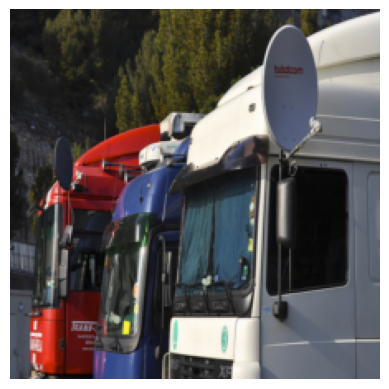

(Longest trained model) Generated caption: <bos>A group of buses parked next to each other.<eos>
(Best test loss model) Generated caption: <bos>A red and white bus parked in front of a brick building.<eos>
(Best BLEU model) Generated caption: <bos>A red double decker bus driving down a street.<eos>
(Best METEOR model) Generated caption: <bos>A red double decker bus driving down a street.<eos>


In [88]:
device = "cpu"
transformer.eval()
transformer_best_state.eval()
transformer_best_bleu.eval()
transformer_best_meteor.eval()

batch = next(iter(train_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu()
img = denormalize(img)
img = img.clamp(0, 1)
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=False)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
# print('Generated token ids:', tokens)
# print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('(Longest trained model) Generated caption:', decoded_caption)

tokens = transformer_best_state.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=False)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best test loss model) Generated caption:', decoded_caption)

tokens = transformer_best_bleu.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=False)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best BLEU model) Generated caption:', decoded_caption)

tokens = transformer_best_meteor.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=False)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best METEOR model) Generated caption:', decoded_caption)

Caption GT:  A bear walking through a field next to a forest.
Input image shape: torch.Size([1, 3, 224, 224])


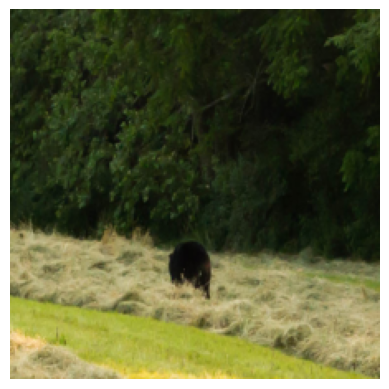

(Longest trained model) Generated caption: <bos>A large grey elephant walking through a lush green field.<eos>
(Best test loss model) Generated caption: <bos>A herd of elephants walking across a lush green field.<eos>
(Best BLEU model) Generated caption: <bos>A bear that is standing in the grass.<eos>
(Best METEOR model) Generated caption: <bos>A man riding on the back of a brown horse.<eos>


In [132]:
batch = next(iter(test_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu()
img = denormalize(img)
img = img.clamp(0, 1)
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
# print('Generated token ids:', tokens)
# print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('(Longest trained model) Generated caption:', decoded_caption)

tokens = transformer_best_state.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best test loss model) Generated caption:', decoded_caption)

tokens = transformer_best_bleu.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best BLEU model) Generated caption:', decoded_caption)

tokens = transformer_best_meteor.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best METEOR model) Generated caption:', decoded_caption)

In [133]:
# export training results to experiments directory
timestamp = time.strftime("%Y%m%d-%H%M%S")
dir = 'experiments/' + 'config_{}'.format(timestamp)
os.makedirs(dir, exist_ok=True)
results_path = os.path.join(dir, 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f)
# export config to results directory
config_path = os.path.join(dir, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f)

# export model weights
model_path = os.path.join(dir, f'cptr_model.pth')
torch.save(transformer.state_dict(), model_path)
best_loss_model_path = os.path.join(dir, f'cptr_best_loss_model.pth')
torch.save(best_model_test_state, best_loss_model_path)
best_bleu_model_path = os.path.join(dir, f'cptr_best_bleu_model.pth')
torch.save(best_model_bleu_state, best_bleu_model_path)
best_meteor_model_path = os.path.join(dir, f'cptr_best_meteor_model.pth')
torch.save(best_model_meteor_state, best_meteor_model_path)